In [5]:
import pandas as pd
import math
import matplotlib.pyplot as plt

# Load dữ liệu
benchmark_df = pd.read_csv('../data/owasp/expected_results_320.csv')
arachni_df = pd.read_csv('../data/arachni/arachni_report.csv')

# Chuẩn hóa benchmark_df
benchmark_df = benchmark_df.rename(columns=lambda x: x.strip())
benchmark_df = benchmark_df.rename(columns={'# test name': 'testcase', 'real vulnerability': 'real_vulnerability', 'category': 'category'})
benchmark_df['category'] = benchmark_df['category'].str.lower()
benchmark_df['testcase'] = benchmark_df['testcase'].str.strip()
benchmark_df = benchmark_df.drop(['Benchmark version: 1.2', '2016-06-1'], axis=1)

print("\n🔎 Preview benchmark_df:")
print(benchmark_df.head())


🔎 Preview benchmark_df:
             testcase    category  real_vulnerability  cwe
0  BenchmarkTest01025  pathtraver                True   22
1  BenchmarkTest01238  pathtraver                True   22
2  BenchmarkTest00528  pathtraver                True   22
3  BenchmarkTest00783  pathtraver                True   22
4  BenchmarkTest02378  pathtraver                True   22


In [6]:
# Tạo mapping Issue → Category (11 CWE liên quan)
issue2category = {
    'LDAP Injection': 'ldapi',
    'SQL Injection': 'sqli',
    'Blind SQL Injection (differential analysis)': 'sqli',
    'Cross-Site Scripting (XSS) in script context': 'xss',
    'Cross-Site Scripting (XSS)': 'xss',
    'Path Traversal': 'pathtraver',
    'Operating system command injection': 'cmdi',
    'Operating system command injection (timing attack)': 'cmdi',
    'HttpOnly cookie': 'securecookie',
    'Insecure cookie': 'securecookie'
}

# Chuẩn hóa testcase và mapping
arachni_df['testcase'] = arachni_df['File'].str.replace('.xml', '', regex=False)
arachni_df['category_arachni'] = arachni_df['Issue'].map(issue2category)
arachni_filtered_df = arachni_df[arachni_df['category_arachni'].notna()]
arachni_grouped = arachni_filtered_df.groupby('testcase')['category_arachni'].apply(set).reset_index()

print("\n🔎 Preview arachni_df:")
print(arachni_df.head())


🔎 Preview arachni_df:
                     File                                                URL  \
0  BenchmarkTest00001.xml  https://192.168.6.149:8443/benchmark/pathtrave...   
1  BenchmarkTest00001.xml  https://192.168.6.149:8443/benchmark/pathtrave...   
2  BenchmarkTest00001.xml  https://192.168.6.149:8443/benchmark/pathtrave...   
3  BenchmarkTest00001.xml  https://192.168.6.149:8443/benchmark/pathtrave...   
4  BenchmarkTest00001.xml  https://192.168.6.149:8443/benchmark/pathtrave...   

                           Issue       Severity            testcase  \
0  Private IP address disclosure            low  BenchmarkTest00001   
1  Private IP address disclosure            low  BenchmarkTest00001   
2           Allowed HTTP methods  informational  BenchmarkTest00001   
3           Interesting response  informational  BenchmarkTest00001   
4                HttpOnly cookie  informational  BenchmarkTest00001   

  category_arachni  
0              NaN  
1              NaN  
2     

In [7]:
# Merge
merged_df = benchmark_df.merge(arachni_grouped, on='testcase', how='left')
merged_df['category_arachni'] = merged_df['category_arachni'].apply(lambda x: x if isinstance(x, set) else set())

# Đánh giá
def evaluate(row):
    category_benchmark = row['category']
    category_arachni_set = row['category_arachni']
    real_vuln = row['real_vulnerability']
    if real_vuln:
        if category_benchmark in category_arachni_set:
            return 'TP'
        else:
            return 'FN'
    else:
        if category_benchmark in category_arachni_set:
            return 'FP'
        else:
            return 'TN'
merged_df['Evaluation'] = merged_df.apply(evaluate, axis=1)
print("\n🔎 Preview merged_df:")
print(merged_df.head(10))



🔎 Preview merged_df:
             testcase    category  real_vulnerability  cwe category_arachni  \
0  BenchmarkTest01025  pathtraver                True   22               {}   
1  BenchmarkTest01238  pathtraver                True   22               {}   
2  BenchmarkTest00528  pathtraver                True   22               {}   
3  BenchmarkTest00783  pathtraver                True   22     {pathtraver}   
4  BenchmarkTest02378  pathtraver                True   22               {}   
5  BenchmarkTest01496  pathtraver                True   22     {pathtraver}   
6  BenchmarkTest02561  pathtraver                True   22     {pathtraver}   
7  BenchmarkTest01111  pathtraver                True   22               {}   
8  BenchmarkTest00698  pathtraver                True   22               {}   
9  BenchmarkTest00216  pathtraver                True   22               {}   

  Evaluation  
0         FN  
1         FN  
2         FN  
3         TP  
4         FN  
5         TP  
6  

In [8]:
# Tạo file CSV chuẩn từ merged_df (format chuẩn để so sánh multi-tool)
arachni_output_rows = []
for _, row in merged_df.iterrows():
    testcase = row['testcase']
    cwe = row['category']
    expected = bool(row['real_vulnerability'])
    detected = cwe in row['category_arachni']
    arachni_output_rows.append({
        'TestCase': testcase,
        'CWE': cwe,
        'Expected': expected,
        'Detected': detected
    })

arachni_output_df = pd.DataFrame(arachni_output_rows)

# Lưu file CSV chuẩn (cho Arachni)
arachni_output_df.to_csv('../data/arachni/arachni_results_format.csv', index=False)
print("\n✅ Đã xuất file Arachni chuẩn từ merged_df: arachni_results_format.csv")
print(arachni_output_df.head())

# Tính tổng TP/FP/FN/TN
summary = merged_df['Evaluation'].value_counts().reindex(['TP', 'FP', 'FN', 'TN'], fill_value=0).reset_index()
summary.columns = ['Metric', 'Count']

print("\n📊 Summary TP, FP, FN, TN:")
print(summary)


✅ Đã xuất file Arachni chuẩn từ merged_df: arachni_results_format.csv
             TestCase         CWE  Expected  Detected
0  BenchmarkTest01025  pathtraver      True     False
1  BenchmarkTest01238  pathtraver      True     False
2  BenchmarkTest00528  pathtraver      True     False
3  BenchmarkTest00783  pathtraver      True      True
4  BenchmarkTest02378  pathtraver      True     False

📊 Summary TP, FP, FN, TN:
  Metric  Count
0     TP     48
1     FP      1
2     FN    112
3     TN    159


In [9]:
TP = summary.loc[summary['Metric'] == 'TP', 'Count'].values[0]
FP = summary.loc[summary['Metric'] == 'FP', 'Count'].values[0]
FN = summary.loc[summary['Metric'] == 'FN', 'Count'].values[0]
TN = summary.loc[summary['Metric'] == 'TN', 'Count'].values[0]

# Tính các chỉ số
def metrics_paper(tp, fp, fn, tn):
    rec = tp / (tp + fn) if tp + fn else 0.0
    prec = tp / (tp + fp) if tp + fp else 0.0
    fpr = fp / (tn + fp) if tn + fp else 0.0

    # F–scores (β = 1, 0.5, 1.5)
    fbeta = lambda b: (1 + b**2) * prec * rec / (b**2 * prec + rec) if (prec + rec) else 0.0
    f1, f05, f15 = fbeta(1), fbeta(0.5), fbeta(1.5)

    # Markedness (TPR+TNR centered)
    denom_mark = math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    mark = ((tp * tn) - (fp * fn)) / denom_mark if denom_mark else 0.0
    
    # Informedness (Youden J)
    inf = rec - fpr

    results = {
        "Rec":  rec,
        "FPR":  fpr,
        "Prec": prec,
        "F-Mes": f1,
        "F0.5": f05,
        "F1.5": f15,
        "Mark": mark,
        "Inf":  inf,
    }

    print("\n=== KẾT QUẢ ===")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

    return results

metrics = metrics_paper(TP, FP, FN, TN)


=== KẾT QUẢ ===
Rec: 0.3000
FPR: 0.0063
Prec: 0.9796
F-Mes: 0.4593
F0.5: 0.6742
F1.5: 0.3814
Mark: 0.4079
Inf: 0.2938


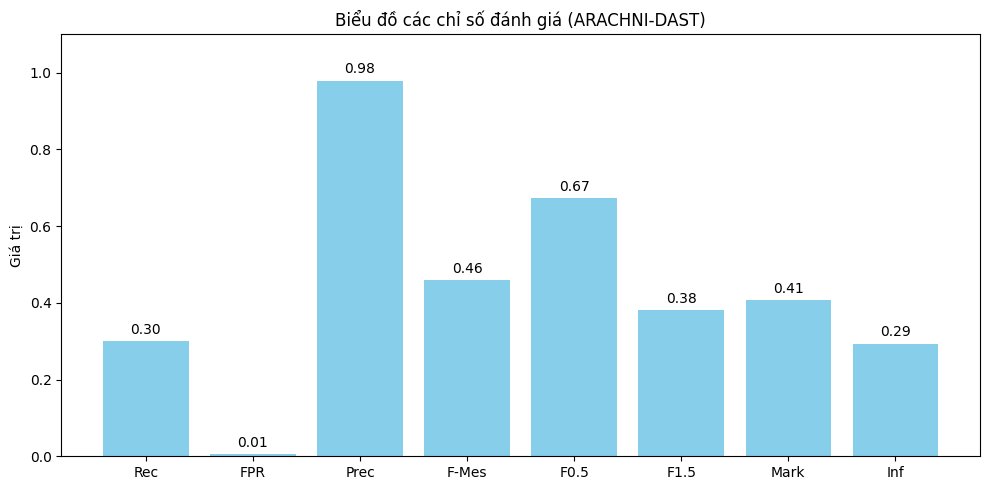

In [10]:
# Vẽ biểu đồ
labels, values = list(metrics.keys()), list(metrics.values())
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(labels, values, color='skyblue')
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
ax.set_ylim(0, 1.1)
ax.set_ylabel('Giá trị')
ax.set_title('Biểu đồ các chỉ số đánh giá (ARACHNI-DAST)')
plt.tight_layout()
plt.show()